In [9]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import json
import os
import re

In [ ]:
# Directory containing JSON files
directory = ".\\Llama\\save_res\\llama"

# Get list of all JSON files in the directory
json_files = glob.glob(os.path.join(directory, "*.json"))

In [ ]:
def parse_filename(filename):
    # Extract attributes using regex
    is_digit = bool(re.search(r"digit_True", filename))
    has_demo = bool(re.search(r"demonstrations_True", filename))
    is_text = bool(re.search(r"text_True", filename))

    # Extract dataset name
    dataset = (
        filename.split("results_")[1].split("_demonstrations")[0].split("_converted")[0]
    )

    return {
        "filename": filename,
        "dataset": dataset,
        "digit": is_digit,
        "demo": has_demo,
        "text": is_text,
    }


# Get all files and create DataFrame
files_df = pd.DataFrame([parse_filename(f) for f in json_files])

# Group by attributes
grouped = files_df.groupby(["digit", "demo", "text"])

# Display groups
for (digit, demo, text), group in grouped:
    print(f"\ndigit={digit}, demo={demo}, text={text}")
    print(group["dataset"].tolist())


digit=False, demo=False, text=False
['AWPNLI', 'comment_subsampled_train', 'headline_subsampled_train', 'NewsNLI', 'QNLI-Stress Test_train', 'QQA_train', 'QQA_train', 'RedditNLI', 'RTE_Quant']

digit=False, demo=False, text=True
['AWPNLI', 'comment_subsampled_train', 'headline_subsampled_train', 'NewsNLI', 'QNLI-Stress Test_train', 'RedditNLI', 'RTE_Quant']

digit=False, demo=True, text=False
['AWPNLI', 'comment_subsampled_train', 'headline_subsampled_train', 'NewsNLI', 'QNLI-Stress Test_train', 'QQA_train', 'QQA_train', 'RedditNLI', 'RTE_Quant']

digit=False, demo=True, text=True
['AWPNLI', 'comment_subsampled_train', 'headline_subsampled_train', 'NewsNLI', 'QNLI-Stress Test_train', 'RedditNLI', 'RTE_Quant']

digit=True, demo=False, text=False
['AWPNLI', 'comment_subsampled_train', 'headline_subsampled_train', 'NewsNLI', 'QNLI-Stress Test_train', 'QQA_train', 'RedditNLI', 'RTE_Quant']

digit=True, demo=True, text=False
['AWPNLI', 'comment_subsampled_train', 'headline_subsampled_train

In [39]:
def analyze_predictions(files_df, datasets_to_analyze):
    results = []

    for dataset in datasets_to_analyze:
        # Get files for this dataset
        dataset_files = files_df[files_df["dataset"].str.contains(dataset)]

        for _, row in dataset_files.iterrows():
            # Load JSON file
            with open(row["filename"], "r") as f:
                data = json.load(f)

            # Extract predictions and answers
            y_true = [d["answer"].lower() for d in data]
            y_pred = [d["preds"].lower() for d in data]

            # Create confusion matrix
            labels = ["entailment", "contradiction", "neutral"]
            cm = confusion_matrix(
                [labels.index(t) if t in labels else -1 for t in y_true],
                [labels.index(p) if p in labels else -1 for p in y_pred],
            )

            # Plot confusion matrix
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
            plt.title(
                f"{dataset}\ndigit={row['digit']}, demo={row['demo']}, text={row['text']}"
            )
            plt.ylabel("True")
            plt.xlabel("Predicted")
            plt.show()

            # Store results
            results.append(
                {
                    "dataset": dataset,
                    "digit": row["digit"],
                    "demo": row["demo"],
                    "text": row["text"],
                    "confusion_matrix": cm,
                }
            )

    return pd.DataFrame(results)

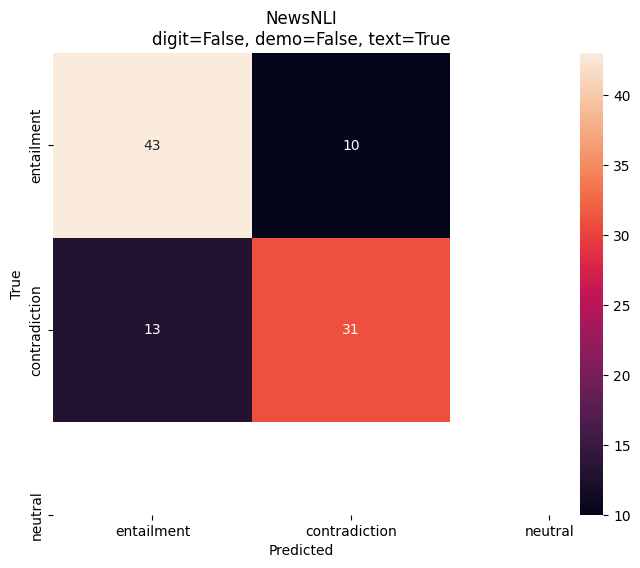

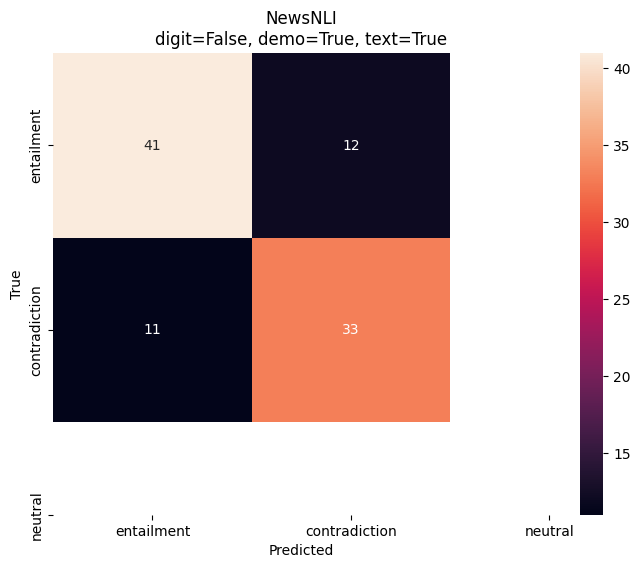

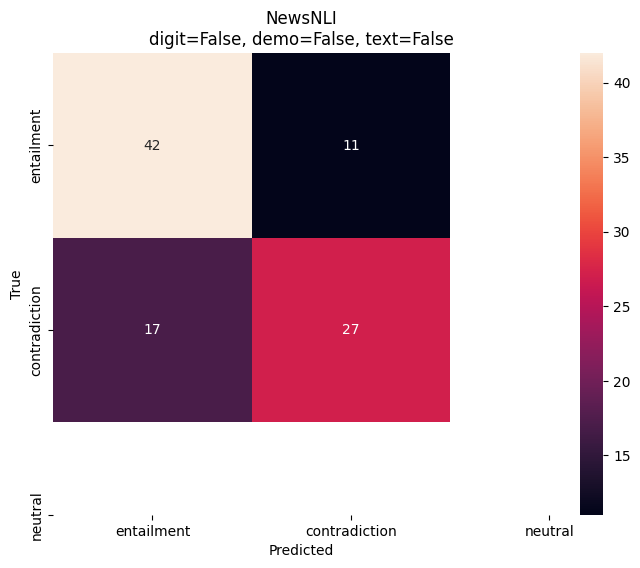

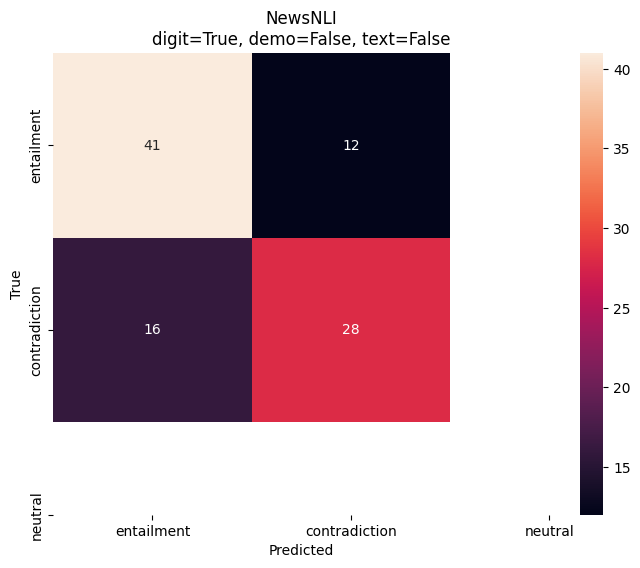

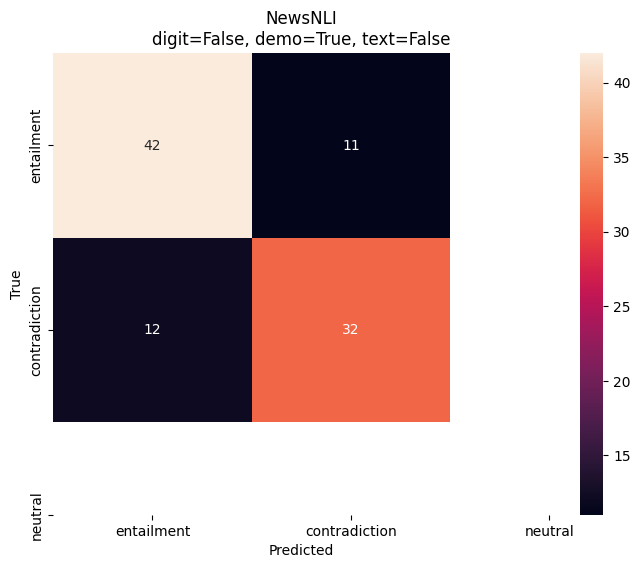

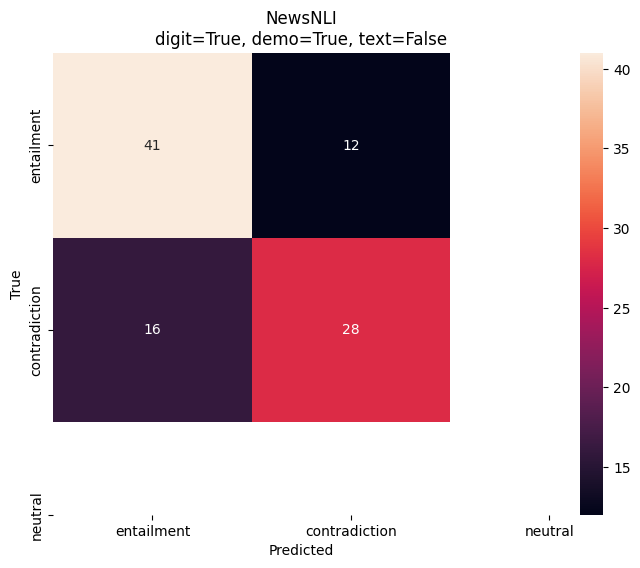

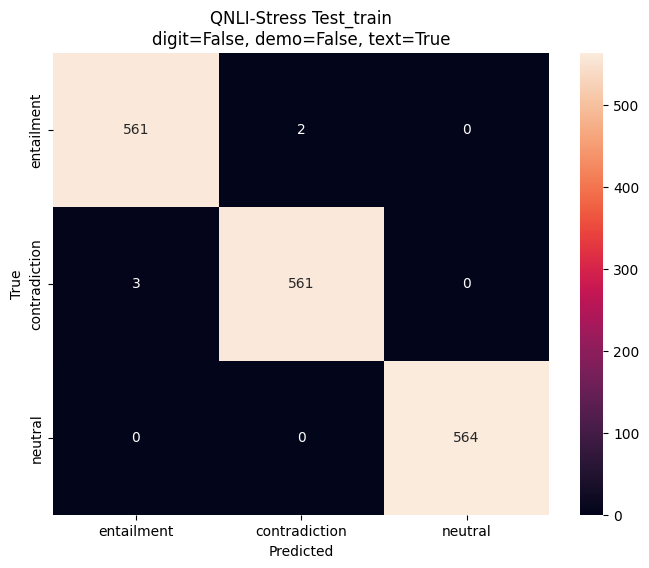

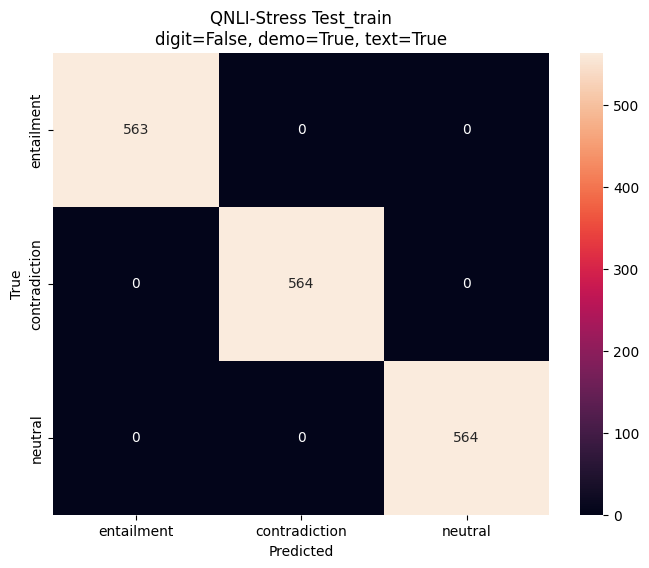

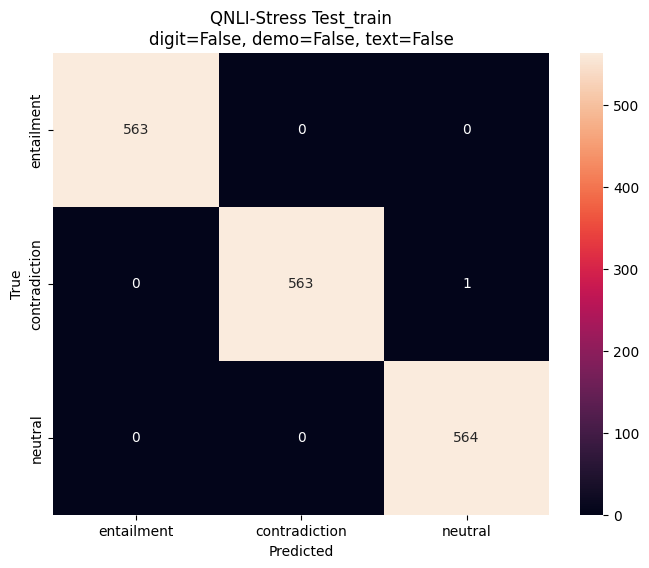

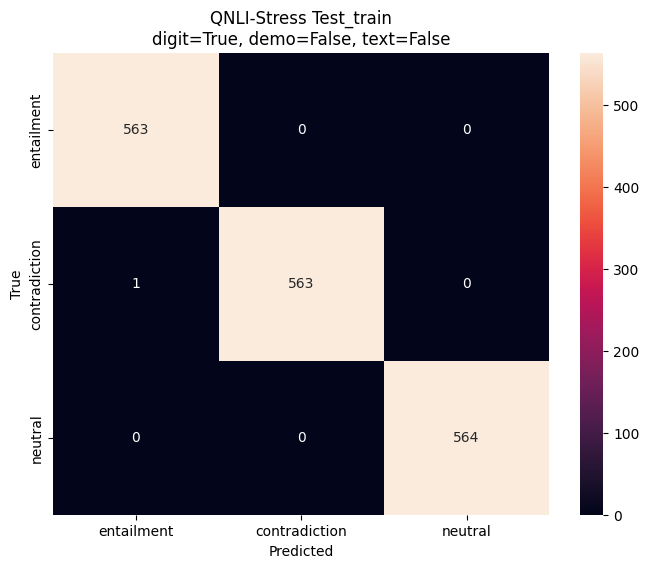

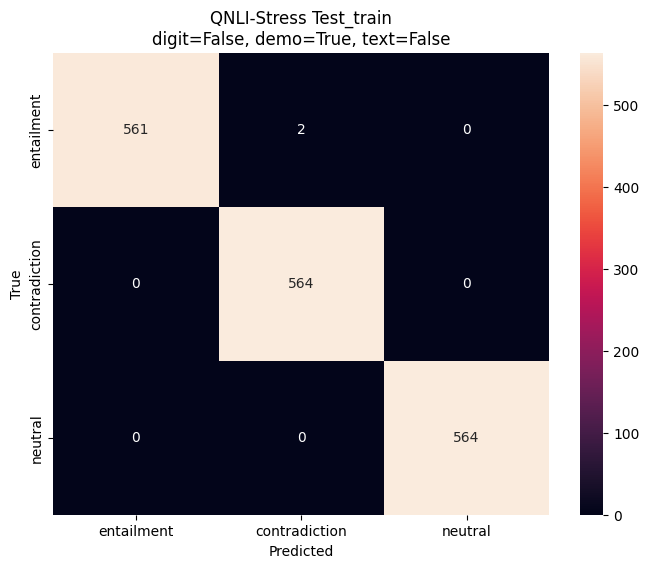

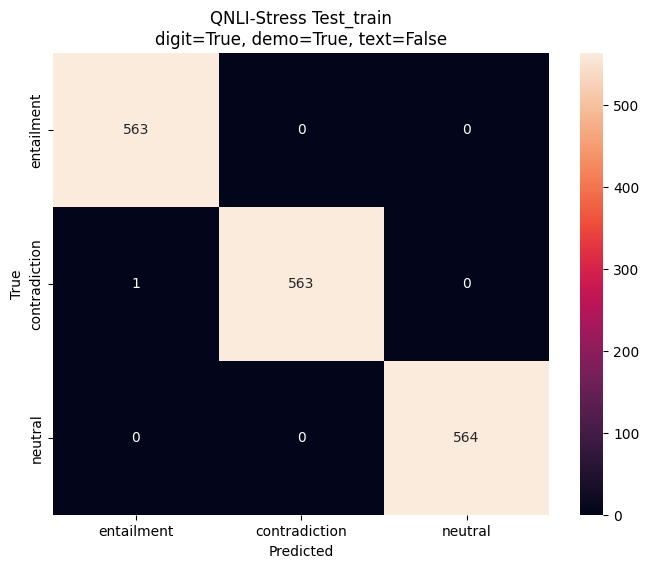

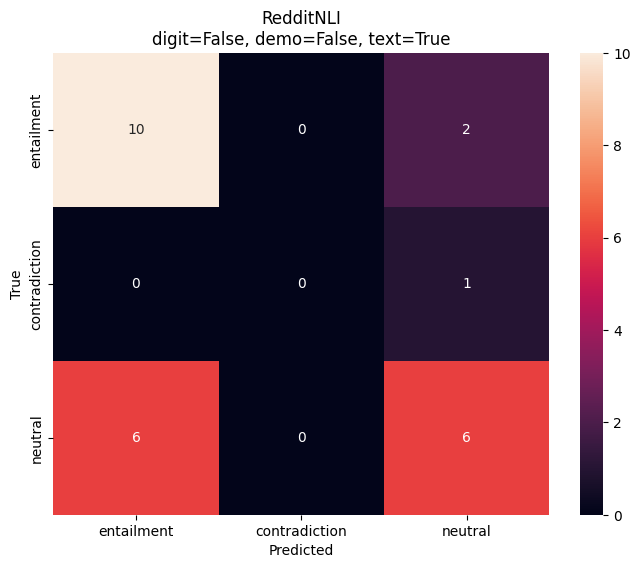

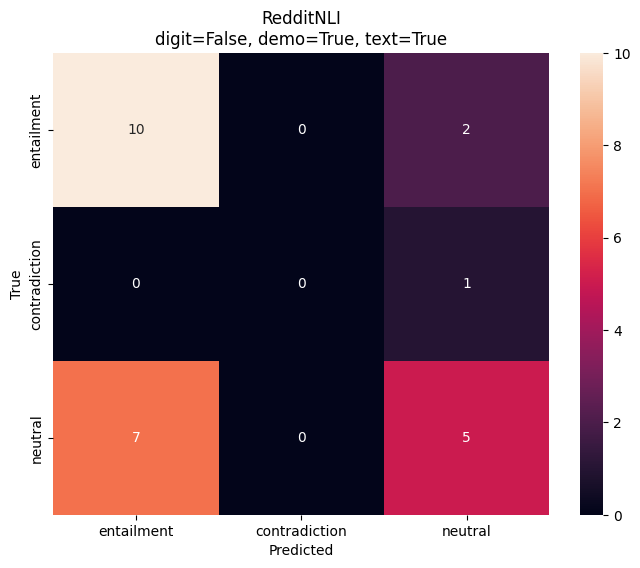

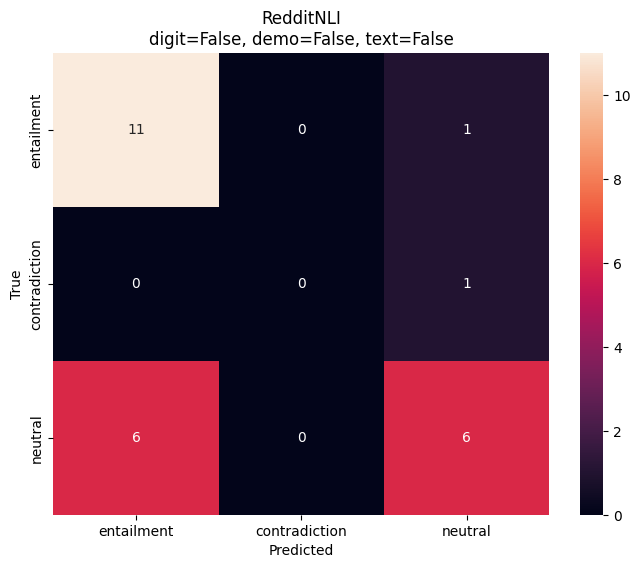

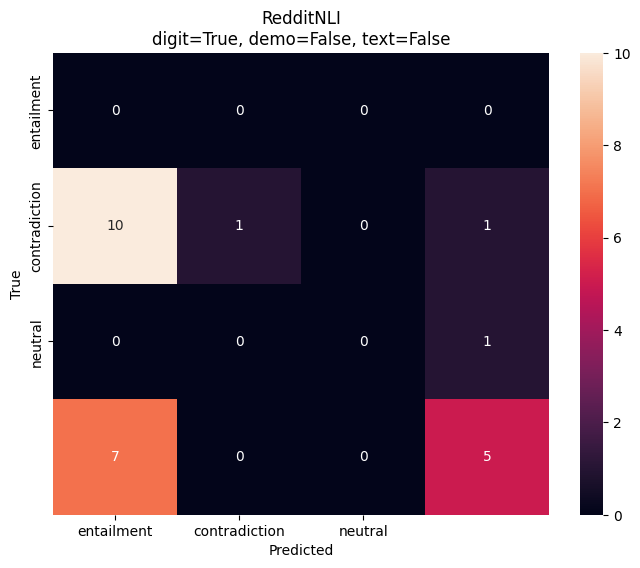

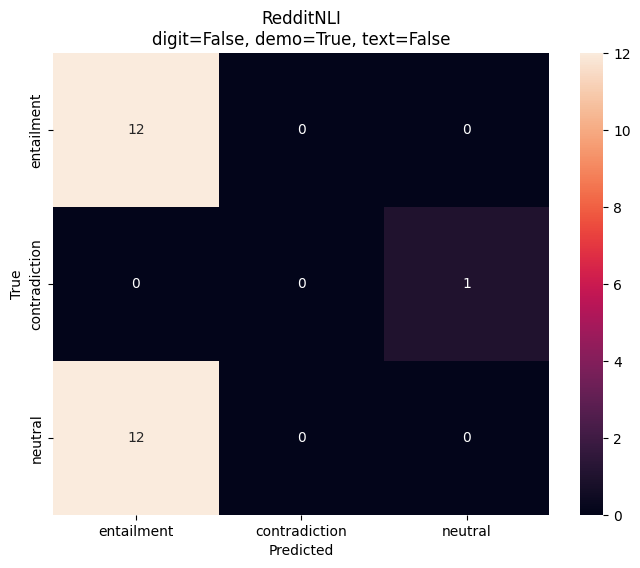

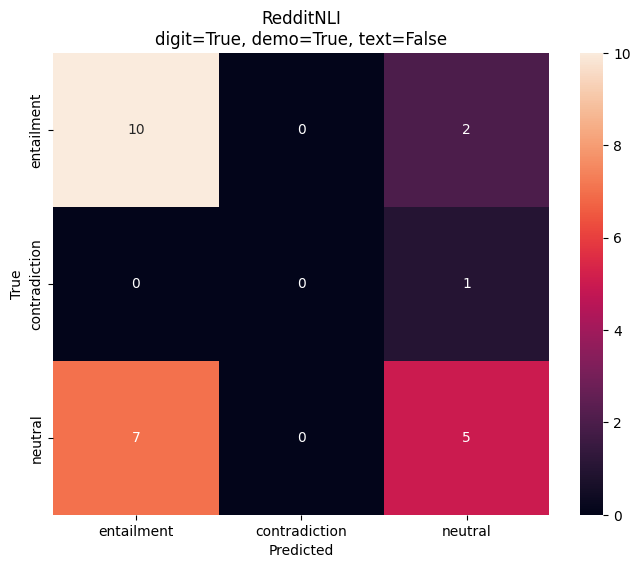

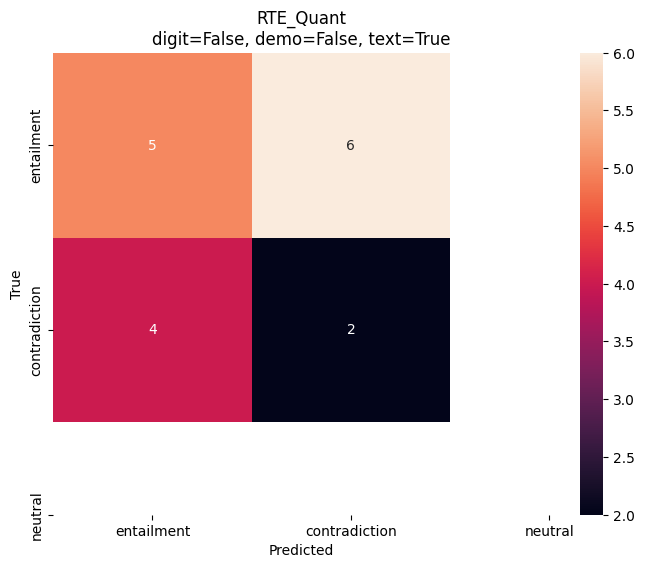

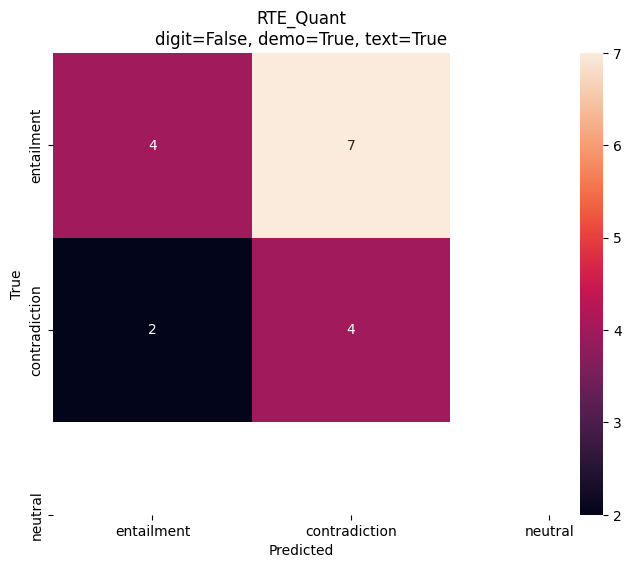

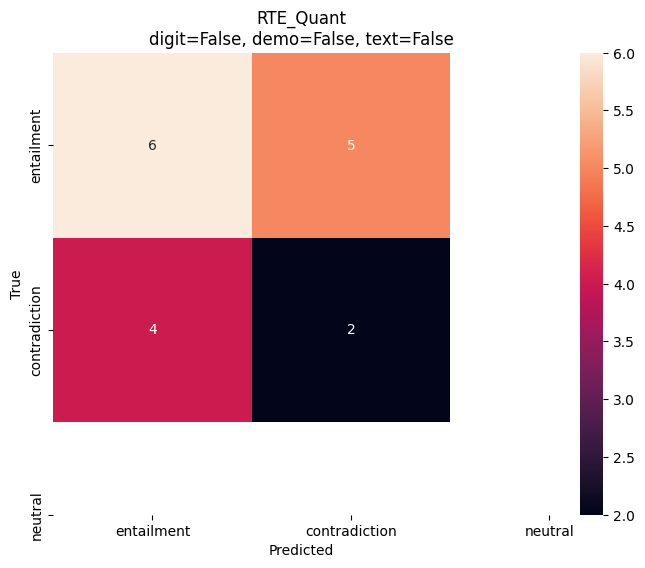

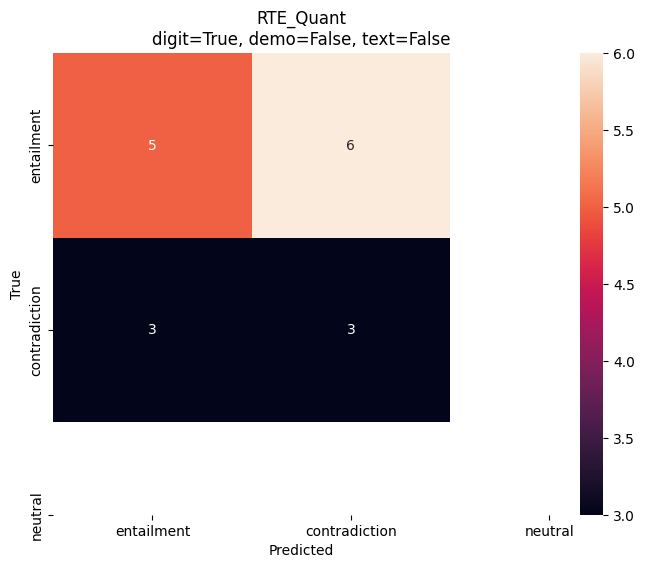

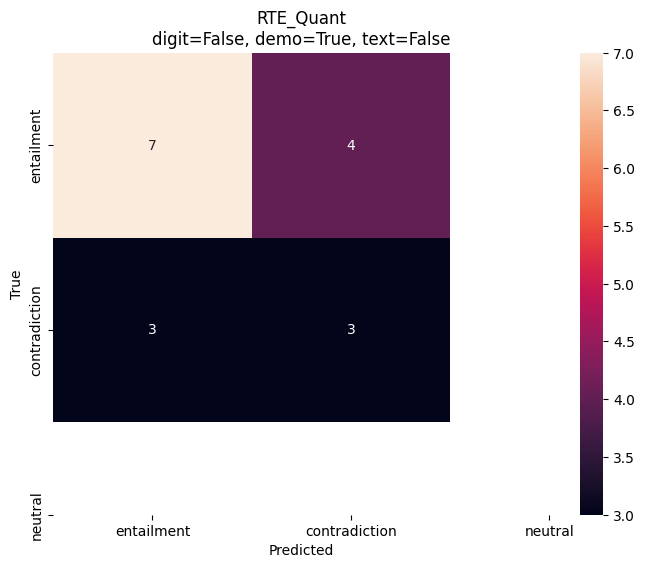

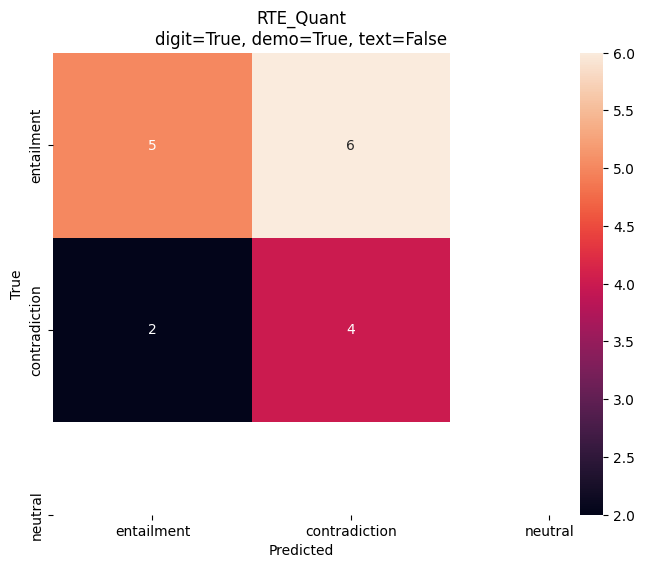


Results for NewsNLI:
   digit   demo   text      confusion_matrix
0  False  False   True  [[43, 10], [13, 31]]
1  False   True   True  [[41, 12], [11, 33]]
2  False  False  False  [[42, 11], [17, 27]]
3   True  False  False  [[41, 12], [16, 28]]
4  False   True  False  [[42, 11], [12, 32]]
5   True   True  False  [[41, 12], [16, 28]]

Results for QNLI-Stress Test_train:
    digit   demo   text                         confusion_matrix
6   False  False   True  [[561, 2, 0], [3, 561, 0], [0, 0, 564]]
7   False   True   True  [[563, 0, 0], [0, 564, 0], [0, 0, 564]]
8   False  False  False  [[563, 0, 0], [0, 563, 1], [0, 0, 564]]
9    True  False  False  [[563, 0, 0], [1, 563, 0], [0, 0, 564]]
10  False   True  False  [[561, 2, 0], [0, 564, 0], [0, 0, 564]]
11   True   True  False  [[563, 0, 0], [1, 563, 0], [0, 0, 564]]

Results for RedditNLI:
    digit   demo   text                                   confusion_matrix
12  False  False   True                 [[10, 0, 2], [0, 0, 1], [6, 0, 6

In [40]:
# Analyze specified datasets
datasets_to_analyze = ["NewsNLI", "QNLI-Stress Test_train", "RedditNLI", "RTE_Quant"]
results_df = analyze_predictions(files_df, datasets_to_analyze)

# Display summary statistics
for dataset in datasets_to_analyze:
    print(f"\nResults for {dataset}:")
    dataset_results = results_df[results_df["dataset"] == dataset]
    print(dataset_results[["digit", "demo", "text", "confusion_matrix"]])

In [12]:
def analyze_stress_test_errors(files_df):
    # Filter QNLI-Stress files
    stress_files = files_df[files_df["dataset"].str.contains("QNLI-Stress")]

    for _, row in stress_files.iterrows():
        print(
            f"\nSettings: digit={row['digit']}, demo={row['demo']}, text={row['text']}"
        )

        # Load predictions
        with open(row["filename"], "r") as f:
            data = json.load(f)

        # Find mismatches
        errors = []
        for item in data:
            if item["answer"].lower() != item["preds"].lower():
                errors.append(
                    {
                        "Statement1": item["statement1"],
                        "Statement2": item["statement2"],
                        "True": item["answer"],
                        "Predicted": item["preds"],
                    }
                )

        # Display errors as DataFrame
        if errors:
            print(f"Total errors: {len(errors)}")
            print(pd.DataFrame(errors))
        else:
            print("No errors found")
        print("-" * 80)


# Run analysis
analyze_stress_test_errors(files_df)


Settings: digit=False, demo=False, text=True
Total errors: 5
                                          Statement1  \
0  In the biology lab of ` ` Jefferson ' ' High S...   
1  If she worked four 16 - hour shifts this week ...   
2  The 2 nd builder builds in 15 days , then how ...   
3  If Matt has five iron coins and five copper co...   
4  How much loss would Indu has suffered had she ...   

                                          Statement2           True  \
0  In the biology lab of ` ` Jefferson ' ' High S...  contradiction   
1  If she worked four more than 16 - hour shifts ...  contradiction   
2  The more than 2 nd builder builds in 15 days ,...  contradiction   
3  If Matt has five iron coins and five copper co...     Entailment   
4  How much loss would Indu has suffered had she ...     Entailment   

       Predicted  
0     entailment  
1     entailment  
2     entailment  
3  contradiction  
4  contradiction  
------------------------------------------------------------

             AWPNLI  NewsNLI  RedditNLI  RTE_Quant
icl_org     41.0959  76.2887       48.0    58.8235
inst_org    49.3151  71.1340       68.0    47.0588
icl_digit   38.3562  71.1340       60.0    52.9412
inst_digit  47.9452  71.1340       24.0    47.0588


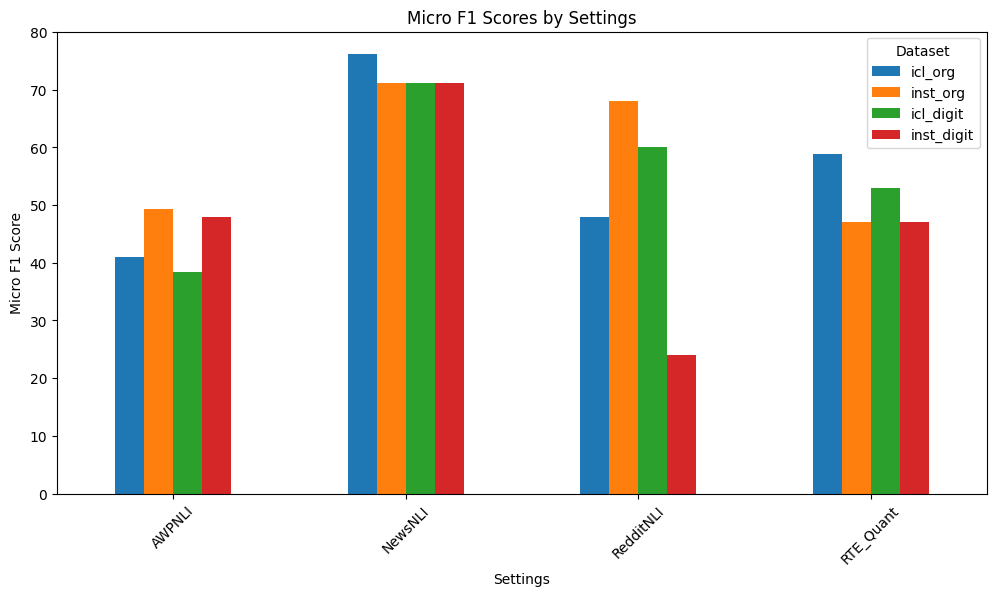

In [29]:
df = pd.read_csv(
    directory + "/" + "qnli_experiment_results.csv", header=[0], index_col=0
)

# Convert columns to numeric
df = df.apply(pd.to_numeric, errors="coerce")
df.dropna(inplace=True)

# Extract micro F1 scores using the correct headers
micro_f1_df = df.iloc[:, [0, 2, 4, 6]]

# Verify data
print(micro_f1_df.head())

# Transpose DataFrame to group by settings
micro_f1_df = micro_f1_df.T

# Plot micro F1 scores by settings
micro_f1_df.plot(kind="bar", figsize=(12, 6))
plt.title("Micro F1 Scores by Settings")
plt.xlabel("Settings")
plt.ylabel("Micro F1 Score")
plt.legend(title="Dataset")
plt.xticks(rotation=45)
plt.show()

In [41]:
import json
from sklearn.metrics import f1_score
import os


def calculate_f1(file_path):
    # Load JSON file
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    # Extract true labels and predictions
    y_true = [
        int(item["magnitude"]) if str(item["magnitude"]).isdigit() else 0
        for item in data
    ]
    y_pred = [
        int(item["preds"]) if str(item["preds"]).isdigit() else 0 for item in data
    ]

    # Calculate micro F1
    micro_f1 = f1_score(y_true, y_pred, average="micro") * 100
    return micro_f1


# File paths
comment_path = (
    r"T5\save_res\results_comment_subsampled_train_demonstrations_True_digit_False.json"
)
headline_path = r"T5\save_res\results_headline_subsampled_train_demonstrations_True_digit_False.json"

# Calculate scores
comment_f1 = calculate_f1(comment_path)
headline_f1 = calculate_f1(headline_path)

print(f"Comment Micro F1: {comment_f1:.2f}%")
print(f"Headline Micro F1: {headline_f1:.2f}%")

Comment Micro F1: 33.11%
Headline Micro F1: 18.82%
